In [17]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
import skimage.io as io
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [6]:
#Train Images Rescaling
from skimage.transform import rescale
from skimage import img_as_uint
import skimage.io as io
import skimage.transform as trans
n = 25

for i in range(0, n):
    path = str(i)+'.tif'
    img = io.imread('train/image/'+path)
    img_resized = rescale(img, (0.835,0.917), anti_aliasing=False)
    img_resized = img_as_uint(img_resized)
    path = str(i)+'.tif'
    io.imsave('train/image_processed/'+path, img_resized)

C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: train/image_processed/0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\i

In [7]:
for i in range(0, n):
    path = str(i)+'.tif'
    img = io.imread('train/label/'+path)
    img_resized = rescale(img, (0.835,0.917), anti_aliasing=False)
    img_resized = img_as_uint(img_resized)
    path = str(i)+'.tif'
    io.imsave('train/label_processed/'+path, img_resized)

C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: train/label_processed/0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: train/label_processed/1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: train/label_processed/2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: train/label_processed/3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: train/label_

In [9]:
#Test Images Rescaling
n = 10
for i in range(0, n):
    path = str(i)+'.tif'
    img = io.imread('test/image/'+path)
    img_resized = rescale(img, (0.83479,0.9172), anti_aliasing=False)
    img_resized = img_as_uint(img_resized)
    path = str(i)+'.tif'
    io.imsave('test/image_processed/'+path, img_resized)

C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: test/image_processed/0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: test/image_processed/1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: test/image_processed/2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: test/image_processed/3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: test/image_processed/4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\SwathiU04\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: test/image_processed/5

In [2]:
# Build U-Net model
def unet_model (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    c1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [26]:
def trainGenerator(batch_size, train_path, img_folder, mask_folder, aug_dict, color_mode = 'grayscale', 
                   mask_color_mode = 'grayscale', target_size = (576, 576), seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(train_path, classes = [img_folder], class_mode = None,
                                                        color_mode = color_mode, target_size = target_size, 
                                                        batch_size = batch_size, seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(train_path, classes = [mask_folder], class_mode = None,
                                                      color_mode = mask_color_mode, target_size = target_size,
                                                      batch_size = batch_size, seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)
        
        
def adjustData(img,mask):
    if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)


def testGenerator(test_path,num_image,target_size = (576,576),as_gray = True):
    for i in range(0, num_image):
        img = io.imread(os.path.join(test_path,"%d.tif"%i),as_gray = as_gray)
        img = img / 255
        img = np.reshape(img,img.shape+(1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img
    

In [4]:
data_gen_args = dict(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                     zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

myGene = trainGenerator(5,'train','image_processed','label_processed',data_gen_args)
model = unet_model(576,576,1)
model.fit_generator(myGene,steps_per_epoch=5,epochs=1,callbacks=None)
model.save('unet_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 576, 576, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 576, 576, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 576, 576, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

conv2d_transpose_4 (Conv2DTrans (None, 576, 576, 64) 32832       conv2d_16[0][0]                  
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 576, 576, 128 0           conv2d_transpose_4[0][0]         
                                                                 conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 576, 576, 64) 73792       concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 576, 576, 64) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 576, 576, 64) 36928       dropout_9[0][0]                  
__________

In [9]:
model = load_model('unet_model.h5')

In [104]:
testGene = testGenerator("test/image_processed/", 10)
results = model.predict_generator(testGene,10,verbose=1)

10/10 [==============================] - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 42 - ETA: 28 - ETA: 14 - 141s 14s/step


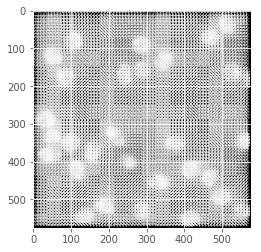

In [132]:
plt.imshow(np.squeeze(results[1]), cmap='Greys', vmin = 0.0, vmax = 0.009)
plt.show()

[[109.51763    40.474136   32.619114  ...  42.518913   57.140785
   78.41651  ]
 [ 75.19875    39.02704    20.253643  ...  25.82894    24.682556
   39.31896  ]
 [ 72.186745   25.502384    8.982543  ...  21.924946   38.431465
   62.123013 ]
 ...
 [ 72.024414   30.642057    5.9908347 ...  21.155008   22.357386
   39.07527  ]
 [ 57.486553   24.87633    21.940996  ...  20.121098   36.87668
   82.595314 ]
 [ 73.324455   79.58464    50.700893  ...  75.03017    70.79944
  102.15432  ]]


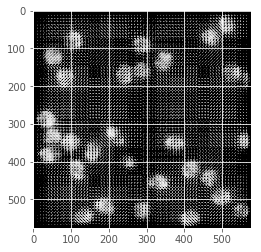

In [123]:
results_ = np.squeeze(np.multiply(results[1],255))
print (results_)
plt.imshow(results_ , cmap='Greys', vmin = 0, vmax = 0.7)
plt.show()